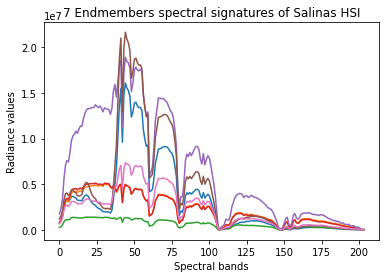

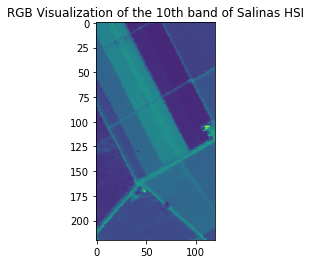

In [4]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

At first, the non zero values need to be kept. Using the np.nonzero function from numpy, the index of every non zero value will be kept in a tuple consisting of two arrays. Each pair of the array is one non zero valued pixel. Using these indexes, a new HSI is formed consisting of only non zero labels.

In [5]:
nonzero = np.nonzero(labels)

In [6]:
np.count_nonzero(labels)

16929

In [7]:
xi = nonzero[0]

In [8]:
yi = nonzero[1]

In [9]:
HSI_new = HSI[xi, yi, :]

In [10]:
HSI_new

array([[441, 558, 787, ...,  26,  11,  16],
       [441, 558, 787, ...,  32,   7,  12],
       [441, 474, 787, ...,  26,   9,  16],
       ...,
       [440, 485, 741, ...,  10,   1,   2],
       [368, 485, 676, ...,  12,   5,   7],
       [368, 401, 676, ...,   0,   5,   2]], dtype=int16)

Now is the time to start with the spectral unmixing using various methods of Least Squares as well as Lasso:
Using the Least Squares method, the parameters theta are being calculated. Each theta consists of 7 values, one for each endmember.

In [11]:
XTXinv =np.linalg.inv(np.dot(endmembers.T, endmembers))
theta_est_ls1 = XTXinv.dot(endmembers.T).dot(HSI_new.T)

In [12]:
theta_est_ls1

array([[  858.3165355 ,   898.53476236,   919.64505355, ...,
          863.31598124,   865.41132257,   874.16288133],
       [ -106.72959981,  -107.82570596,  -109.80885879, ...,
           67.63458815,    66.83761233,    66.93031451],
       [  -51.62809902,   -60.56297093,   -62.56046507, ...,
         -424.20581482,  -423.06256916,  -425.60930209],
       ...,
       [ 1293.02553495,  1352.36710996,  1384.14308012, ...,
         1258.30664594,  1261.61158718,  1274.49249155],
       [-1050.95585689, -1101.19616774, -1127.28707664, ...,
        -1125.55701948, -1127.90690575, -1138.98984457],
       [   80.22127185,    87.58026204,    90.11122761, ...,
          267.65434765,   267.24496128,   269.18871173]])

In [13]:
np.shape(theta_est_ls1)

(7, 16929)

In [14]:
HSI_new.shape

(16929, 204)

In [15]:
materials = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']

In [16]:
len(materials)

7

After calculating the thetas, 7 abundance maps are being plotted, one for each material. The materials were put into a list for ease of use when giving title to each map. Subplots are used to plot these 7 abundance maps.

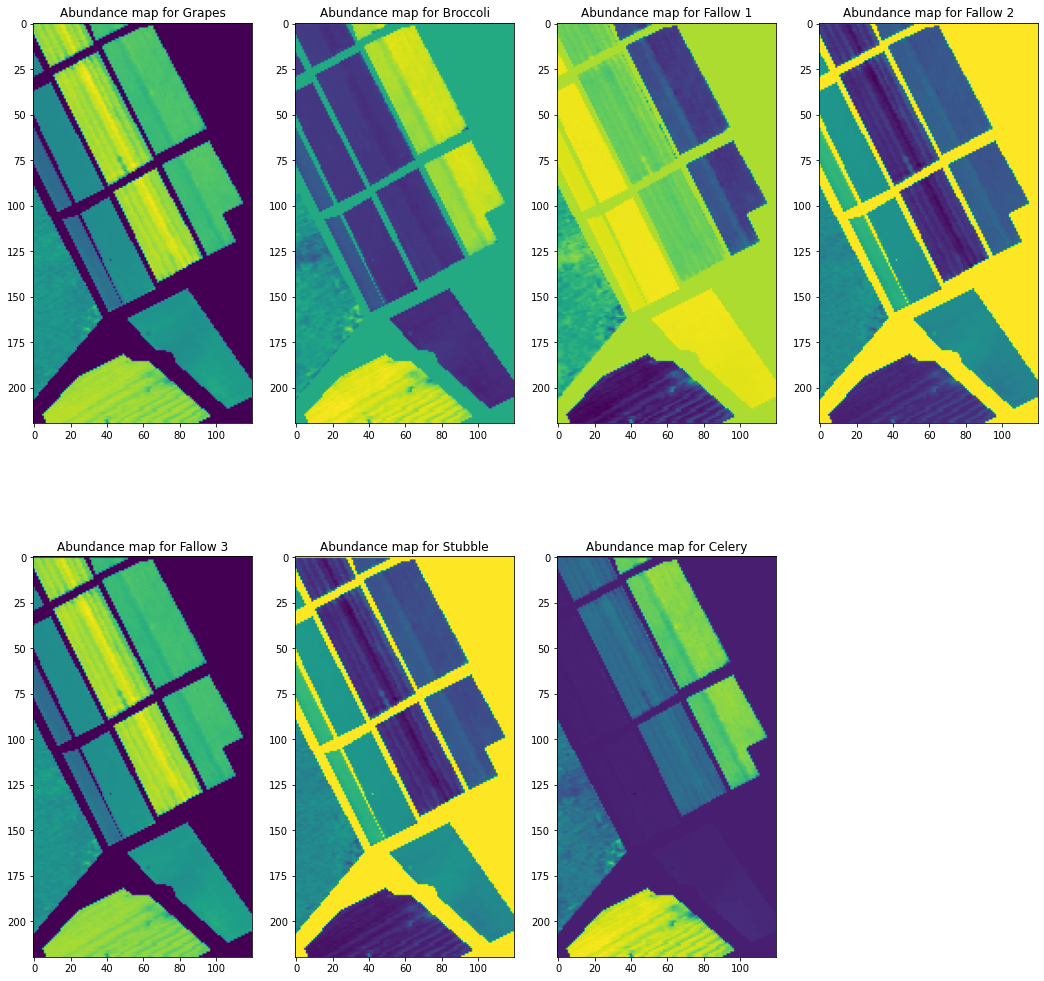

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(18, 18))
axs = axs.ravel()
abundance_maps= np.zeros((220,120,7))
for i in range(7):

    abundance_maps[xi, yi, i] = theta_est_ls1[i, :]

    axs[i].imshow(abundance_maps[:, :, i])
    axs[i].set_title(f'Abundance map for {materials[i]}')
fig.delaxes(axs[-1])

The reconstruction error is calculated (for each non-zero class label). The quantity ||yi−Xθi||^2 is calculated for each pixel and then the average is taken by dividing it to np.count_nonzero function.

In [18]:
reconstraction_error1 = np.linalg.norm(HSI_new.T - np.dot(endmembers, theta_est_ls1)) ** 2 / np.count_nonzero(labels)
print(f'Least Squares Reconstraction Error: {reconstraction_error1}')

Least Squares Reconstraction Error: 1.7736299590314862e+21


Reviewing the reconstruction error - which is very high - as well as the abundance maps for each of the materials, it is easy to see that the methods of Least Squares without any constraints does not yield good results, not giving clear images of each material's abundance.

Now, the spectral unmixing will be performed using Least Squares with sum to one constraint.
A method called SLSQP will be used from the scipy.optimize.minimize() module. A function with the purpose of being minimized will be created and a constraint will be added for the minimize method.

In [19]:
# Define the minimization function.
def function1(x, A, B):
    return (np.linalg.norm(A.dot(x) - B))**2

In [20]:
# Add constraints for the minimization function.
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

In [21]:
# Calculate thetas.
theta_zeros = np.zeros((1,7))
theta_est_ls2 = []
for i in range(np.count_nonzero(labels)):
    res = scipy.optimize.minimize(function1, theta_zeros, args=(endmembers, HSI_new[i,:]), method='SLSQP', tol='1e-6', constraints=constraints)
    theta_est_ls2.append(res.x)

In [22]:
theta_est_ls2

[array([-1.08336082e+08, -8.22476306e+07,  2.36075286e+07,  7.01922801e+07,
        -3.72200349e+06,  7.55429673e+07,  2.49025334e+07]),
 array([ 0.0046408 ,  0.25576734,  1.74212428, -0.87162007,  0.11062145,
         0.02224138, -0.26377516]),
 array([ 0.00465089,  0.25573796,  1.74214679, -0.87161261,  0.11063749,
         0.02223678, -0.26379728]),
 array([-8.40255267e+08, -1.11489206e+09,  2.14904861e+06,  1.36472903e+09,
        -1.31153212e+08,  6.59695906e+08,  5.97265528e+07]),
 array([ 0.00458881,  0.25552923,  1.74203146, -0.87123917,  0.1105536 ,
         0.02228458, -0.26374851]),
 array([-6.11809290e+07, -5.86007570e+07, -2.56649136e+08,  1.00341966e+08,
         4.39761687e+06,  3.02073895e+07,  4.66529259e+07]),
 array([ 0.00460403,  0.25563208,  1.74217997, -0.87150056,  0.11063548,
         0.02228504, -0.26383604]),
 array([ 0.00461577,  0.25563838,  1.74216556, -0.87151689,  0.11064062,
         0.0222738 , -0.26381723]),
 array([ 0.0046315 ,  0.25562885,  1.7421046

By using the same reconstruction error equation, the error is again calculated.

In [23]:
theta_est_ls2 = np.asarray(theta_est_ls2).T

In [24]:
reconstraction_error2 = np.linalg.norm(HSI_new.T - np.dot(endmembers, theta_est_ls2)) ** 2 / np.count_nonzero(labels)
print(f'Least Squares Reconstraction Error: {reconstraction_error2}')

Least Squares Reconstraction Error: 4.2031763017841703e+39


The equation error is even higher by many degrees from the previous one, indicating that the method will not yield clear images.

Using the same subplots as before, the abundance maps are calculated.

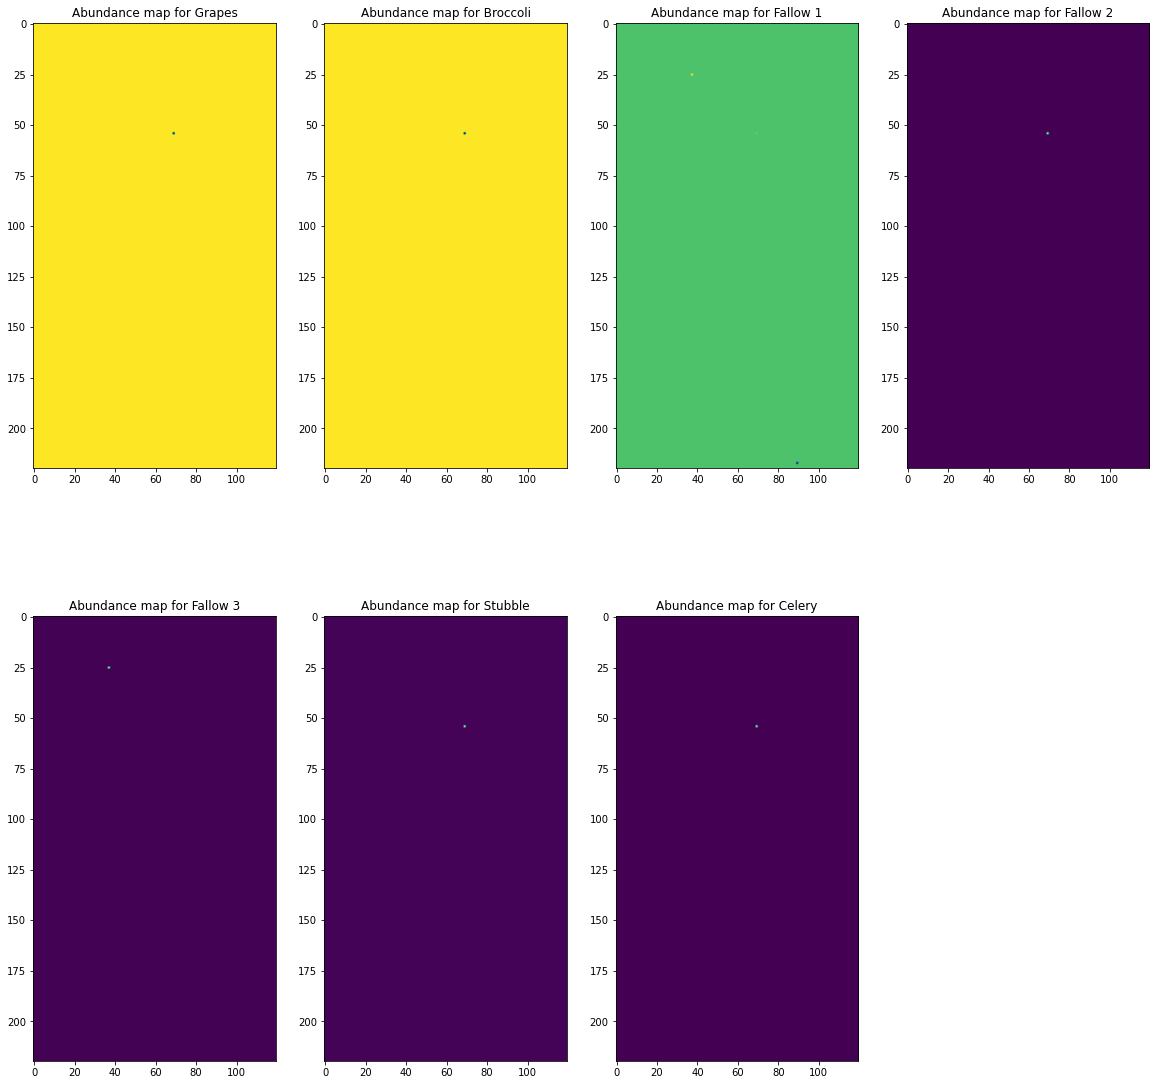

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(20, 20))
axs = axs.ravel()
abundance_maps2= np.zeros((220,120,7))
for i in range(7):

    abundance_maps2[xi, yi, i] = theta_est_ls2[i, :]

    axs[i].imshow(abundance_maps2[:, :, i])
    axs[i].set_title(f'Abundance map for {materials[i]}')
fig.delaxes(axs[-1])

The images consist of one color -unicolour images- which give zero information about the abundance of materials whatsoever.

Using the non-negativity constraint, the Least Squares method is used. The nnls module from the scipy.optimize package is used here.

In [26]:
theta_est_ls3 = []
for i in range(np.count_nonzero(labels)):
    theta, norm = scipy.optimize.nnls( endmembers, HSI_new[i, :])
    theta_est_ls3.append(theta)

In [27]:
theta_est_ls3 = np.asarray(theta_est_ls3).T

In [28]:
theta_est_ls3

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.18741019e-04, 4.18300882e-04, 4.21248116e-04],
       [5.44149932e-05, 3.80987300e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.31172098e-05, 3.32013811e-05, 2.38474795e-05],
       ...,
       [2.10613931e-04, 2.41631326e-04, 2.49967750e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.72723370e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.39526524e-05, 1.08447383e-05, 6.87612563e-06, ...,
        2.26794349e-05, 2.23931315e-05, 1.90892585e-05]])

In [29]:
reconstraction_error3 = np.linalg.norm(HSI_new.T - np.dot(endmembers, theta_est_ls3)) ** 2 / np.count_nonzero(labels)
print(f'Least Squares Reconstraction Error: {reconstraction_error3}')

Least Squares Reconstraction Error: 156104.18220644665


The reconstruction error using the non-negativity constraint is much lower. This reconstruction error indicates that the images will be clearer and sufficient information can be taken from them.

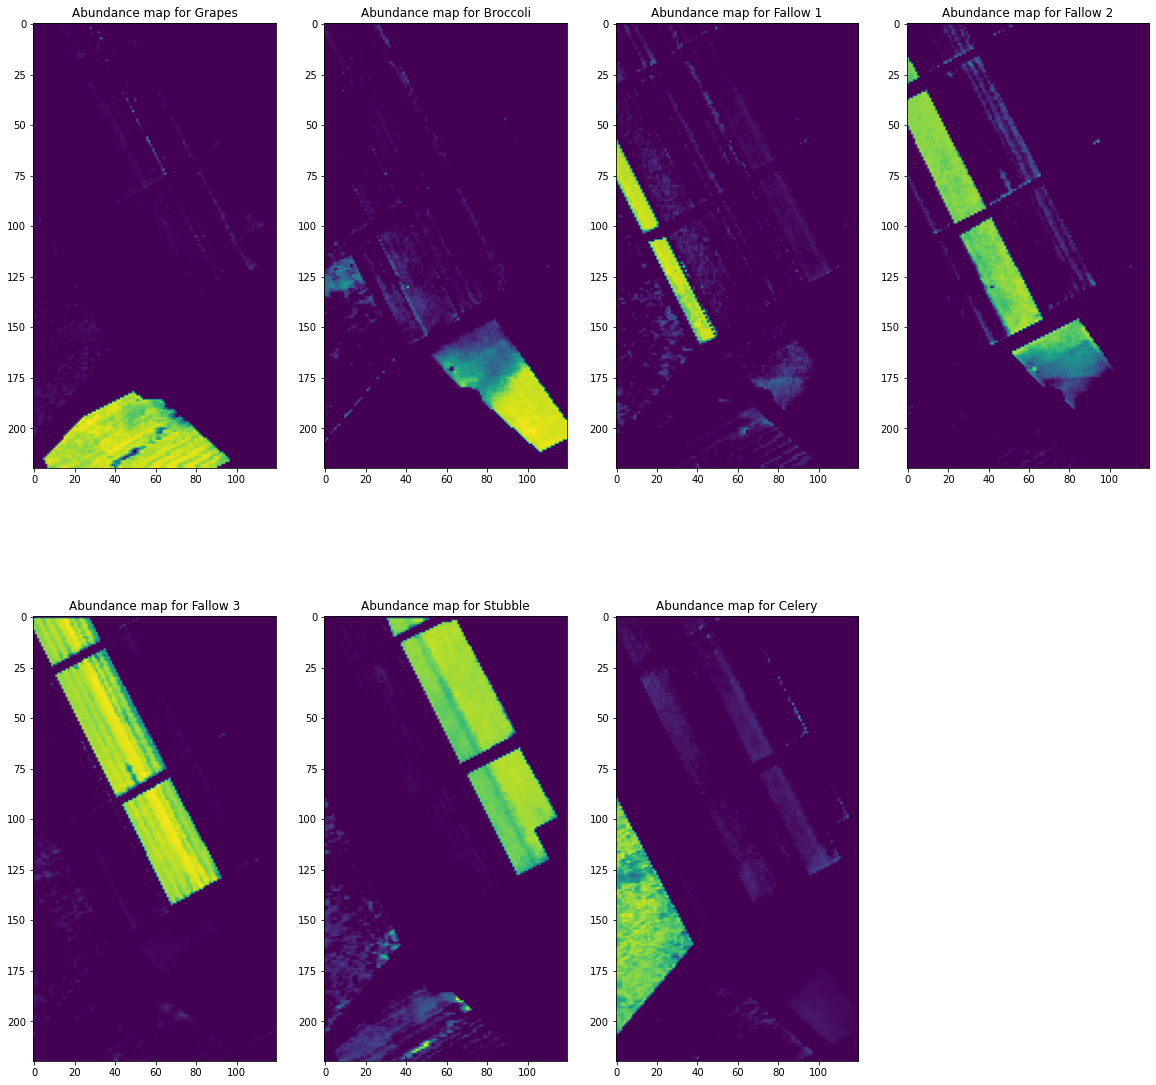

In [30]:
fig, axs = plt.subplots(2, 4, figsize=(20, 20))
axs = axs.ravel()
abundance_maps3= np.zeros((220,120,7))
for i in range(7):

    abundance_maps3[xi, yi, i] = theta_est_ls3[i, :]

    axs[i].imshow(abundance_maps3[:, :, i])
    axs[i].set_title(f'Abundance map for {materials[i]}')
fig.delaxes(axs[-1])

It can be seen that -as expected when reviewing the error- the plots give a clear image of each material.

Now, the Least Squares method is used with both previous constraints. During the scipy.optimize.minimize, besides the constraints used before, bounds are used for the non-negativity constraint.

In [31]:
theta_est_ls4 = []
for i in range(np.count_nonzero(labels)):
    res = scipy.optimize.minimize(function1, theta_zeros, args=(endmembers, HSI_new[i,:]), bounds=[(0, None)] * 7, method='SLSQP', tol='1e-6', constraints=constraints)
    theta_est_ls4.append(res.x)

In [32]:
theta_est_ls4 = np.asarray(theta_est_ls4).T

In [33]:
reconstruction_error4 = np.linalg.norm(HSI_new.T - np.dot(endmembers, theta_est_ls4)) ** 2 / np.count_nonzero(labels)
print(f'Least Squares Reconstruction Error: {reconstruction_error4}')

Least Squares Reconstruction Error: 2.592839879156746e+21


The reconstruction error for the least squares method using both constraints, is of the same size with the no constraints method. It is as if the two constraints negate its other since one gives great results while the other is double the size of the no constraints error.

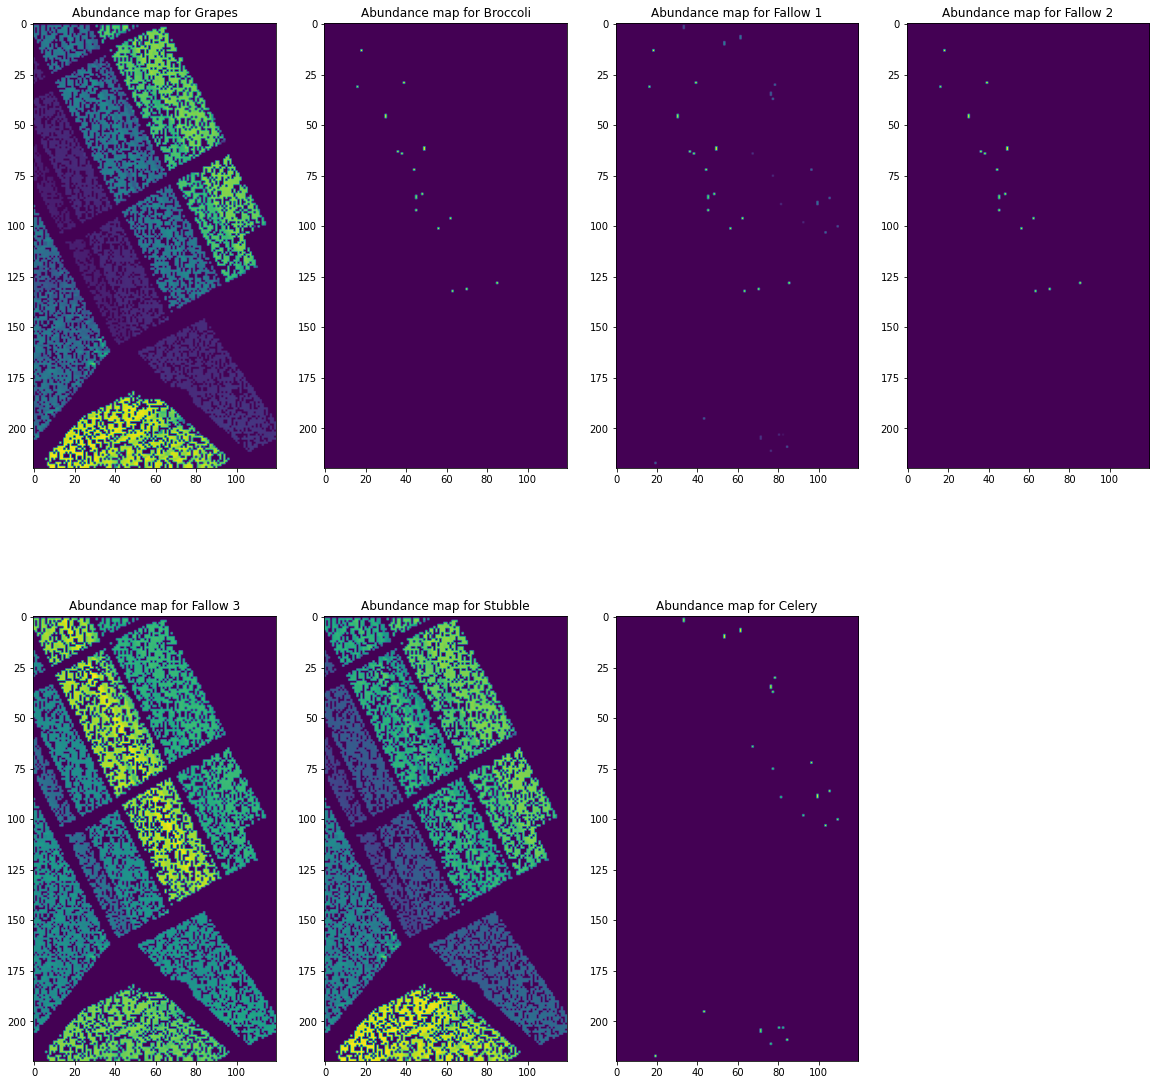

In [34]:
fig, axs = plt.subplots(2, 4, figsize=(20, 20))
axs = axs.ravel()
abundance_maps4= np.zeros((220,120,7))
for i in range(7):

    abundance_maps4[xi, yi, i] = theta_est_ls4[i, :]

    axs[i].imshow(abundance_maps4[:, :, i])
    axs[i].set_title(f'Abundance map for {materials[i]}')
fig.delaxes(axs[-1])

The plotted images, once again don't give valuable information about each material's abundances. Four of them are completely unclear while the rest of them show all fields.

For this part of the project, the Lasso Regression is used.

In [35]:
from sklearn import linear_model
theta_est_lasso = []
lasso = linear_model.Lasso(alpha=50, positive = True, fit_intercept=False, max_iter=1e7)
for i in range(np.count_nonzero(labels)):
    lasso.fit(endmembers, HSI_new[i,:])
    theta=lasso.coef_
    theta_est_lasso.append(theta)

In [36]:
theta_est_lasso = np.asarray(theta_est_lasso).T

In [37]:
reconstruction_error_lasso = np.linalg.norm(HSI_new.T - np.dot(endmembers, theta_est_lasso)) ** 2 / np.count_nonzero(labels)
print(f'Lasso Reconstruction Error: {reconstruction_error_lasso}')

Lasso Reconstruction Error: 157446.90768046965


The reconstruction error for the lasso spectral unmixing is low. This is optimal and the images are expected to give clear information about the materials of the field.

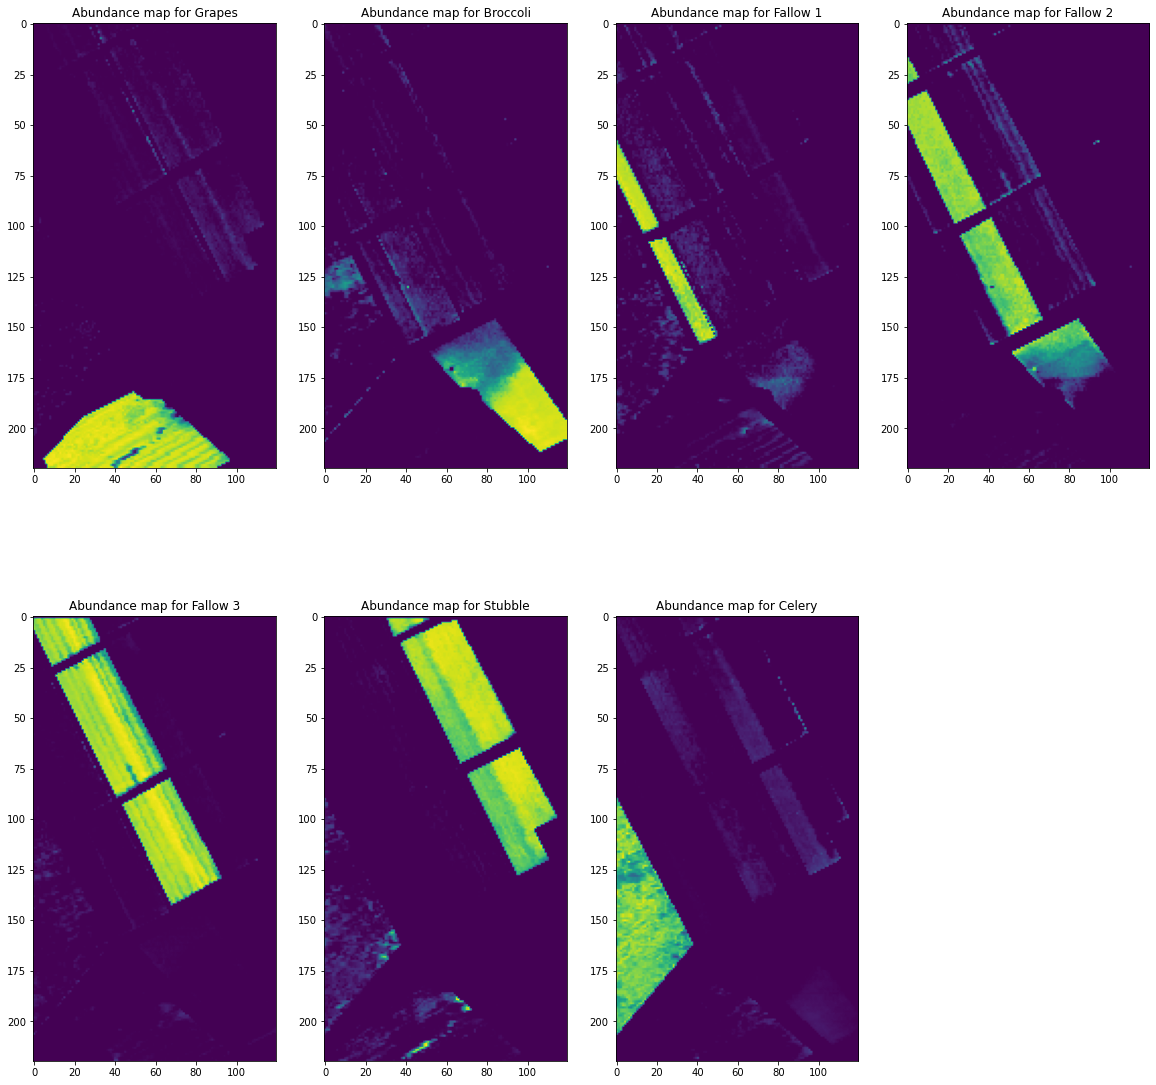

In [38]:
fig, axs = plt.subplots(2, 4, figsize=(20, 20))
axs = axs.ravel()
abundance_maps_lasso= np.zeros((220,120,7))
for i in range(7):

    abundance_maps_lasso[xi, yi, i] = theta_est_lasso[i, :]

    axs[i].imshow(abundance_maps_lasso[:, :, i])
    axs[i].set_title(f'Abundance map for {materials[i]}')
fig.delaxes(axs[-1])

As expected, the plotted images give very clear information about the pixels with each material. The only "outlier" seems to be fallow 2 which does not have so clear boundaries at the bottom.

### Part 1. B
Comparing every spectral unmixing method's reconstruction errors, it is very easy to see which ones are the best.
> a) The Least Squares with non-negativity constraint as well as the Lasso spectral unmixing have almost the same reconstruction errors. Both are around 157000 which is an optimal value. Both of these methods, give clear images of each material allowing for the gathering of valuable information with each plot.
> b) The Least squares with no constraints and with both constraints have the same degree of error which is very high and sub-optimal. Most of the plots after using these methods give some form of image which however does not give information that can be used regarding the materials.
> c) Lastly, the sum to one constraint gives an enormous reconstruction error which does not allow its use. The images plotted are unicolor with zero information in them.

By comparing the images plotted with the image given by the ground truth, it can be seen that the boundaries given by the Lasso and the Least Squares with non-negativity constraint are the correct ones. Each "classification" of the materials is correct.

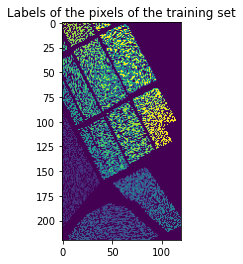

In [39]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold

In [41]:
X_train = HSI[Training_Set != 0]
y_train = Training_Set[Training_Set != 0]

X_test = HSI[Test_Set!=0]
y_test = Test_Set[Test_Set!=0]

X_op = HSI[Operational_Set != 0]
y_op = Operational_Set[Operational_Set != 0]

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

For the second part, the non-zero class labels are considered only. Different classifiers are to be used in order to classify each pixel to each of the 7 classes. The classifiers to be used are the Naive Bayes classifier, the minimum Euclidean distance classifier, the k-nearest neighbor classifier and the Bayesian classifier.
In the beginning, the data set is cut into pieces. The training set, the test set and lastly, an operational set is also used.
Each classifier is trained performing a 10-fold cross-validation (repeating it 10 times). After that, to review its classifier a confusion matrix, a classification report are computed and the success rate is calculated.

In [43]:
scoresnb=cross_val_score(GaussianNB(), X=X_train, y=y_train,cv=10,scoring='accuracy')
print(f'Mean of Validation Error: {round(np.mean(1-scoresnb),4)}')
print(f'Standard Deviation of Error: {round(np.std(scoresnb),4)}')

Mean of Validation Error: 0.0262
Standard Deviation of Error: 0.016


In [44]:
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [45]:
confusion_matrix(y_test, predictions)

array([[545,   0,   0,   0,   0,   0,   3],
       [  5, 512,   0,   0,   0,   0,   0],
       [  0,   0, 470,   0,  42,   0,   0],
       [  0,   0,   0, 210,   4,   0,   0],
       [  0,   0,  12,   4, 547,   0,   0],
       [  1,   0,   2,   0,   0, 995,   0],
       [  6,   0,   0,   0,   0,   0, 874]], dtype=int64)

In [55]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       548
           2       1.00      0.99      1.00       517
           3       0.97      0.92      0.94       512
           4       0.98      0.98      0.98       214
           5       0.92      0.97      0.95       563
           6       1.00      1.00      1.00       998
           7       1.00      0.99      0.99       880

    accuracy                           0.98      4232
   macro avg       0.98      0.98      0.98      4232
weighted avg       0.98      0.98      0.98      4232



In [50]:
print(f'Success rate of Naive Bayes test set: {round(np.trace(confusion_matrix(y_test, predictions))/np.sum(confusion_matrix(y_test, predictions)),6)}')

Success rate of Naive Bayes test set: 0.981333


In [47]:
predictions_op = model.predict(X_op)

In [48]:
confusion_matrix(y_op, predictions_op)

array([[597,   0,   2,   0,   0,   0,   1],
       [  6, 563,   0,   0,   0,   0,   0],
       [  0,   0, 428,   2,  32,   0,   0],
       [  0,   0,   0, 187,   5,   0,   0],
       [  0,   0,   8,   5, 501,   0,   0],
       [  2,   0,   0,   0,   0, 986,   0],
       [  5,   0,   0,   0,   0,   0, 902]], dtype=int64)

In [57]:
print(classification_report(y_op, predictions_op))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       600
           2       1.00      0.99      0.99       569
           3       0.98      0.93      0.95       462
           4       0.96      0.97      0.97       192
           5       0.93      0.97      0.95       514
           6       1.00      1.00      1.00       988
           7       1.00      0.99      1.00       907

    accuracy                           0.98      4232
   macro avg       0.98      0.98      0.98      4232
weighted avg       0.98      0.98      0.98      4232



In [49]:
print(f'Success rate of Naive Bayes operational set: {round(np.trace(confusion_matrix(y_op, predictions_op))/np.sum(confusion_matrix(y_op, predictions_op)),6)}')

Success rate of Naive Bayes operational set: 0.983932


The accuracy score (and success rate) of both test and operational sets are close to 1 (around 0.98 each) meaning that the model has really good results. By reviewing also the confusion matrix, it can be seen that the diagonals have almost all the data which is what is optimal.

The KNeighborsClassifier is now used. Seven models' validation errors are compared and the best model of these will be selected for the predictions.

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
list_of_k = [3,5,7,9,11,13,15]
k_errors = []
for k in list_of_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    scoresknn= cross_val_score(knn, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print(f'The Validation error mean of {k} neighbors is: {round(np.mean(scoresknn),6)}\nThe Validation error standard deviation of {k} neighbors is: {round(np.std(scoresknn), 6)}')
    k_errors.append(np.mean(scoresknn))
print(f'The best model has {list_of_k[k_errors.index(max(k_errors))]} neighbor(s)')

The Validation error mean of 3 neighbors is: 0.991138
The Validation error standard deviation of 3 neighbors is: 0.012962
The Validation error mean of 5 neighbors is: 0.989838
The Validation error standard deviation of 5 neighbors is: 0.014536
The Validation error mean of 7 neighbors is: 0.989838
The Validation error standard deviation of 7 neighbors is: 0.014137
The Validation error mean of 9 neighbors is: 0.988184
The Validation error standard deviation of 9 neighbors is: 0.014223
The Validation error mean of 11 neighbors is: 0.986885
The Validation error standard deviation of 11 neighbors is: 0.014794
The Validation error mean of 13 neighbors is: 0.98594
The Validation error standard deviation of 13 neighbors is: 0.015093
The Validation error mean of 15 neighbors is: 0.985703
The Validation error standard deviation of 15 neighbors is: 0.01488
The best model has 3 neighbor(s)


The model that yields the best validation error is the model consisting of 3 neighbors. All the models have good results but the best one is the k=3 model which will be used for the predictions.

Using the knn for 3 neighbors as found above, the model is trained and predictions are made.

In [65]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)
predictions_knn = model_knn.predict(X_test)

In [66]:
confusion_matrix(y_test, predictions_knn)

array([[548,   0,   0,   0,   0,   0,   0],
       [  0, 516,   0,   0,   0,   0,   1],
       [  0,   0, 510,   0,   2,   0,   0],
       [  0,   0,   0, 213,   1,   0,   0],
       [  0,   0,   5,   1, 556,   1,   0],
       [  0,   0,   0,   0,   0, 998,   0],
       [  1,   0,   0,   0,   0,   0, 879]], dtype=int64)

In [73]:
print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       548
           2       1.00      1.00      1.00       517
           3       0.99      1.00      0.99       512
           4       1.00      1.00      1.00       214
           5       0.99      0.99      0.99       563
           6       1.00      1.00      1.00       998
           7       1.00      1.00      1.00       880

    accuracy                           1.00      4232
   macro avg       1.00      1.00      1.00      4232
weighted avg       1.00      1.00      1.00      4232



In [71]:
print(f'Success rate of k-nearest neighbors for the test set: {round(np.trace(confusion_matrix(y_test, predictions_knn))/np.sum(confusion_matrix(y_test, predictions_knn)),6)}')

Success rate of k-nearest neighbors for the test set: 0.997164


In [68]:
predictions_knn_op = model_knn.predict(X_op)

In [69]:
confusion_matrix(y_op, predictions_knn_op)

array([[600,   0,   0,   0,   0,   0,   0],
       [  0, 569,   0,   0,   0,   0,   0],
       [  0,   0, 459,   2,   1,   0,   0],
       [  0,   0,   0, 190,   2,   0,   0],
       [  0,   0,   8,   3, 503,   0,   0],
       [  0,   0,   0,   0,   0, 988,   0],
       [  1,   0,   0,   0,   0,   0, 906]], dtype=int64)

In [74]:
print(classification_report(y_op, predictions_knn_op))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       569
           3       0.98      0.99      0.99       462
           4       0.97      0.99      0.98       192
           5       0.99      0.98      0.99       514
           6       1.00      1.00      1.00       988
           7       1.00      1.00      1.00       907

    accuracy                           1.00      4232
   macro avg       0.99      0.99      0.99      4232
weighted avg       1.00      1.00      1.00      4232



In [72]:
print(f'Success rate of k-nearest neighbors for the operational set: {round(np.trace(confusion_matrix(y_op, predictions_knn_op))/np.sum(confusion_matrix(y_op, predictions_knn_op)),6)}')

Success rate of k-nearest neighbors for the operational set: 0.995983


The K-NN results are even better than the naive bayes results. The success rates of both the test and operational sets are above 99.5%, which means that almost always the class assignment will be correct. The same can be seen from reviewing the confusion matrix which shows that almost all non-diagonal values are zero. The classification report shows that both the precision and the recall of the model for each of the materials is almost 1.00.

In [75]:
from sklearn import discriminant_analysis

In [84]:
scoresbayes = cross_val_score(discriminant_analysis.LinearDiscriminantAnalysis(), X=X_train, y=y_train, cv=10, scoring='accuracy')
print(f'The Validation error mean of Bayes Classifier is: {round(np.mean(1-scoresbayes),6)}\nThe Validation error standard deviation of Bayes Classifier is: {round(np.std(scoresbayes), 6)}')

The Validation error mean of Bayes Classifier is: 0.004727
The Validation error standard deviation of Bayes Classifier is: 0.00591


In [77]:
model_bayes = discriminant_analysis.LinearDiscriminantAnalysis()
model_bayes.fit(X_train, y_train)
predictions_bayes = model_bayes.predict(X_test)

In [78]:
confusion_matrix(y_test, predictions_bayes)

array([[548,   0,   0,   0,   0,   0,   0],
       [  0, 517,   0,   0,   0,   0,   0],
       [  0,   0, 512,   0,   0,   0,   0],
       [  0,   0,   0, 209,   5,   0,   0],
       [  1,   0,   2,   5, 555,   0,   0],
       [  0,   0,   0,   0,   0, 998,   0],
       [  0,   0,   0,   0,   0,   0, 880]], dtype=int64)

In [79]:
print(f'Success rate of Bayes Classifier for the test set: {round(np.trace(confusion_matrix(y_test, predictions_bayes))/np.sum(confusion_matrix(y_test, predictions_bayes)),6)}')

Success rate of Bayes Classifier: 0.996928


In [80]:
predictions_bayes_op = model_bayes.predict(X_op)

In [81]:
confusion_matrix(y_op, predictions_bayes_op)

array([[600,   0,   0,   0,   0,   0,   0],
       [  0, 568,   0,   0,   0,   0,   1],
       [  0,   0, 462,   0,   0,   0,   0],
       [  0,   0,   0, 183,   9,   0,   0],
       [  0,   0,   0,   4, 510,   0,   0],
       [  0,   0,   0,   0,   0, 988,   0],
       [  0,   0,   0,   0,   0,   0, 907]], dtype=int64)

In [82]:
print(f'Success rate of Bayes Classifier for the operational set: {round(np.trace(confusion_matrix(y_op, predictions_bayes_op))/np.sum(confusion_matrix(y_op, predictions_bayes_op)),6)}')

Success rate of Bayes Classifier for the operational set: 0.996692


For both the test and operational sets, the success rate is 99.7% concerning the Bayesian classification.

### Part 2. B

In [95]:
print('Naive Bayes Confusion Matrix\n')
print(confusion_matrix(y_op, predictions_op),'\n')
print('K-NN 3 neighbors Confusion Matrix\n')
print(confusion_matrix(y_op, predictions_knn_op),'\n')
print('Bayesian Classification Confusion Matrix\n')
print(confusion_matrix(y_op, predictions_bayes_op),'\n')

Naive Bayes Confusion Matrix

[[597   0   2   0   0   0   1]
 [  6 563   0   0   0   0   0]
 [  0   0 428   2  32   0   0]
 [  0   0   0 187   5   0   0]
 [  0   0   8   5 501   0   0]
 [  2   0   0   0   0 986   0]
 [  5   0   0   0   0   0 902]] 

K-NN 3 neighbors Confusion Matrix

[[600   0   0   0   0   0   0]
 [  0 569   0   0   0   0   0]
 [  0   0 459   2   1   0   0]
 [  0   0   0 190   2   0   0]
 [  0   0   8   3 503   0   0]
 [  0   0   0   0   0 988   0]
 [  1   0   0   0   0   0 906]] 

Bayesian Classification Confusion Matrix

[[600   0   0   0   0   0   0]
 [  0 568   0   0   0   0   1]
 [  0   0 462   0   0   0   0]
 [  0   0   0 183   9   0   0]
 [  0   0   0   4 510   0   0]
 [  0   0   0   0   0 988   0]
 [  0   0   0   0   0   0 907]] 



The comparison of matrices is done using the operational set which is a set not known by the classifiers.
The confusion matrix for the Naive Bayes has a few non-zero, non-diagonal values.
As far as the K-NN and Bayesian classifiers are concerned, they have no non-zero, non-negative values, considering also the fact that values 1 or 2 are negligible.

All of the used classification methods yield great success rates, above 98% for both the test and the operational sets. However, by comparing the success rates of each classification method, it can be seen that the method with the best success rate is the Bayesian classification method. Its success rate is almost 99.8% which means that almost every time, the classification of each pixel will be successful. By also reviewing the confusion matrices, one can see that for the Bayesian classification there is only one non-diagonal value that is not zero and one more that is only 1.

Since the success rates are almost the same, there is no point in comparing them with each other through a plot (A histogram would be used).

### Part 3

Through spectral unmixing with Least Squares and Lasso, abundance maps of each material's pixel location is plotted. On the other hand, through classification methods each pixel is assigned to a specific class or material in this case. It can be observed that while the least squares spectral unmixing results are not always good - with the exception of Least Squares with non negative constraint -, the classification of the pixels is optimal, no matter the classification method used. Although the above is true, the optimal solution would be to use the best spectral unmixing method, which in this case would be the Lasso Regressor, as well as the best classification method.